# Simple model

Assumptions:
* 2D motion
* Inertial frame == World frame

In [14]:
import sympy as sp

In [15]:
sp.init_printing()

In [16]:
x, y, xdot, ydot, theta = sp.symbols('x y v_x v_y theta')
state = [x, y, theta, xdot, ydot]
a_x, a_y = sp.symbols('a_x a_y') # in body frame

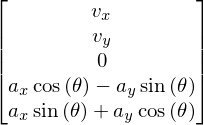

In [17]:
g = sp.Matrix([xdot, ydot, 0, sp.cos(theta) * a_x - sp.sin(theta) * a_y, sp.sin(theta) * a_x + sp.cos(theta) * a_y])
g.transpose()
g

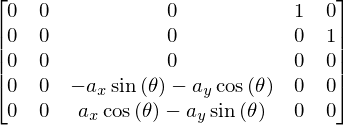

In [18]:
G = g.jacobian(state)
G

# Measurements

In [49]:
h_dmp = sp.Matrix([theta])
h_dmp

In [50]:
H_dmp = h_dmp.jacobian(state)
H_dmp

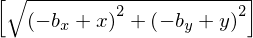

In [46]:
# Generate the measurement function for beacons
b_x, b_y = sp.symbols('b_x b_y') # beacon position
h_b = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])
h_b

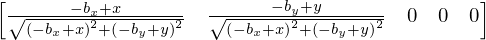

In [56]:
H_b = h_b.jacobian(state)
H_b

# Evaluation of the performances